# This notebook is to forecast temperature for future dates in Melbourne using historical data

## The structure of case study is as follows:


### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1. Loading and preprocessing data
### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2. Exploratory Analysis
#### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;i. Univariate distribution
#### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;ii. Bivariate analysis
### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3. Missing value imputation
### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;4. Building time series model (Seasonal ARIMA)
#### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;i. Finding Optimum hyper-parameters using grid search
#### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;ii. Building Model
#### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;iii. Checking for the pattern in residuals
#### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;iv. Validation
### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;5. Forecasting for the future dates
### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;6. Next steps for improving the results


In [1]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
warnings.filterwarnings("ignore")
data = pd.read_csv("melbourne_weather.csv", header = 1)
data['datetime'] = pd.to_datetime(data['datetime'])
data = data.set_index('datetime')
data.sort_index(inplace=True)
data.head()

,0,windchill,conditions,events,precip,gustspeed,windspeed,winddir,visibility,pressure,humidity,dewpoint,heatindex,temp,time,date
datetime,,,,,,,,,,,,,,,,
2006-01-01 00:00:00,8,NaN,NaN,NaN,-,NaN,4.6,ene,NaN,29.57,66,63,NaN,72,12:00 am,2006-01-01
2006-01-01 03:00:00,7,NaN,NaN,NaN,-,NaN,6.9,nnw,NaN,29.57,26,54,NaN,84,3:00 am,2006-01-01
2006-01-01 06:00:00,6,NaN,NaN,NaN,-,NaN,NaN,calm,6.0,29.66,60,58,NaN,69,6:00 am,2006-01-01
2006-01-01 09:00:00,5,NaN,NaN,NaN,-,NaN,4.6,nw,NaN,29.68,43,59,NaN,78,9:00 am,2006-01-01
2006-01-01 12:00:00,4,NaN,NaN,NaN,-,NaN,16.1,west,NaN,29.76,49,62,NaN,78,12:00 pm,2006-01-01


# Exploratory Analysis and Preprocessing

## Let's try to understand data

In this step first, we will look for the values in all columns. After that, we will look for the distribution. Then we will treat any missing values and outlier


In [3]:
data.index

DatetimeIndex(['2006-01-01 00:00:00', '2006-01-01 03:00:00',
               '2006-01-01 06:00:00', '2006-01-01 09:00:00',
               '2006-01-01 12:00:00', '2006-01-01 15:00:00',
               '2006-01-01 18:00:00', '2006-01-01 21:00:00',
               '2006-01-02 00:00:00', '2006-01-02 03:00:00',
               ...
               '2017-02-18 06:00:00', '2017-02-18 07:00:00',
               '2017-02-18 09:00:00', '2017-02-19 00:00:00',
               '2017-02-19 01:00:00', '2017-02-19 03:00:00',
               '2017-02-19 04:00:00', '2017-02-19 06:00:00',
               '2017-02-19 07:00:00', '2017-02-19 09:00:00'],
              dtype='datetime64[ns]', name='datetime', length=35319, freq=None)

In [4]:
data.describe()

,0,windchill,gustspeed,windspeed,visibility,pressure,humidity,dewpoint,heatindex,temp
count,35319.000000,0.0,0.0,33448.000000,2179.000000,34958.000000,35319.000000,35319.000000,0.0,35319.000000
mean,17660.000000,NaN,NaN,10.719786,3.596145,30.033812,62.509924,48.508536,NaN,59.392820
std,10195.861415,NaN,NaN,5.397847,1.799220,0.226992,19.812560,6.879541,NaN,10.406417
min,1.000000,NaN,NaN,1.200000,0.000000,29.180000,4.000000,26.000000,NaN,30.000000
25%,8830.500000,NaN,NaN,6.900000,2.000000,29.880000,49.000000,44.000000,NaN,52.000000
50%,17660.000000,NaN,NaN,10.400000,4.000000,30.040000,63.000000,48.000000,NaN,58.000000
75%,26489.500000,NaN,NaN,13.800000,5.000000,30.190000,78.000000,53.000000,NaN,65.000000
max,35319.000000,NaN,NaN,39.100000,6.000000,30.680000,100.000000,74.000000,NaN,115.000000


In [5]:
print(data['conditions'].value_counts())
print('\n')
print(data['events'].value_counts())
print('\n')
print(data['precip'].value_counts())
print('\n')
print(data['winddir'].value_counts())

overcast                 8600
unknown precipitation     922
partly cloudy               1
heavy rain showers          1
Name: conditions, dtype: int64


rain    1
Name: events, dtype: int64


-    35319
Name: precip, dtype: int64


north    7746
ssw      3320
south    2790
west     2527
sw       2495
se       2271
sse      1906
calm     1871
ese      1837
nnw      1722
wnw      1597
nw       1381
wsw      1321
nne       952
east      808
ne        427
ene       348
Name: winddir, dtype: int64


### Based on our observation we can remove the following column

0        : Contains just index numbers

windchill: All Nan

gustspeed: All Nan

heatindex: All Nan

events   : Only one observation rest all Nan

precip   : All Nan (in string format "-")

time     : Already captured in datetime

date     : Already captured in datetime

In [6]:
data.drop(['0', 'windchill', 'gustspeed', 'heatindex', 'events', 'precip', 'time', 'date'], axis=1, inplace=True)

In [7]:
data.tail(10)

,conditions,windspeed,winddir,visibility,pressure,humidity,dewpoint,temp
datetime,,,,,,,,
2017-02-18 06:00:00,overcast,10.4,wsw,NaN,29.81,56,49,60
2017-02-18 07:00:00,NaN,10.4,west,NaN,29.82,59,48,58
2017-02-18 09:00:00,NaN,10.4,west,NaN,29.85,53,48,61
2017-02-19 00:00:00,NaN,10.4,west,NaN,29.88,47,44,59
2017-02-19 01:00:00,NaN,11.5,west,NaN,29.88,49,43,57
2017-02-19 03:00:00,NaN,9.2,wnw,NaN,29.85,55,43,55
2017-02-19 04:00:00,NaN,11.5,nw,NaN,29.83,57,43,54
2017-02-19 06:00:00,NaN,12.7,nnw,NaN,29.81,53,43,55
2017-02-19 07:00:00,NaN,12.7,nnw,NaN,29.81,56,43,54


### Now let's check the distribution of all numeric variables

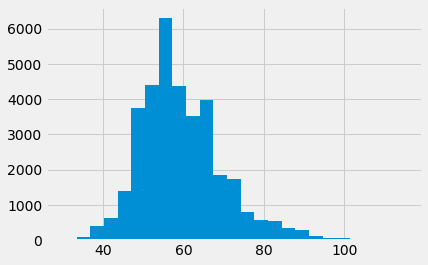

In [8]:
plt.hist(data['temp'].values, bins=25)
plt.show()

### I believe the temperature is in Fahrenheit with the range around (30, 105) and median around 50. It seems reasonable


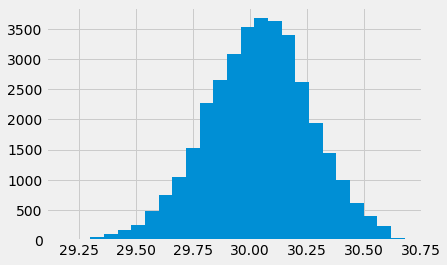

In [9]:
plt.hist(data['pressure'].dropna().values, bins=25)
plt.show()

### Unit here is in 'inhg' seems normally distributed

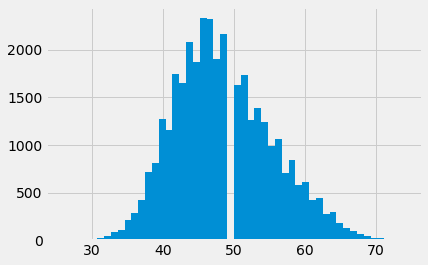

In [10]:
plt.hist(data['dewpoint'].dropna().values, bins=50)
plt.show()

### Dew point is the temperature to which air must be cooled to become saturated with water vapour. The values we have is in Fahrenhite. Following is the perception (from Wikipedia):

<pre>
'''
Dew point 	            Human perception	                                         Relative humidity at 32 °C (90 °F)
gt 26 °C 	gt 80 °F 	Severely high, even deadly for asthma related illnesses 	 73% and higher
24–26 °C 	75–80 °F 	Extremely uncomfortable, fairly oppressive 	                 62–72%
21–24 °C 	70–74 °F 	Very humid, quite uncomfortable 	                         52–61%
18–21 °C 	65–69 °F 	Somewhat uncomfortable for most people at upper edge 	     44–51%
16–18 °C 	60–64 °F 	OK for most, but all perceive the humidity at upper edge 	 37–43%
13–16 °C 	55–59 °F 	Comfortable 	                                             31–36%
10–12 °C 	50–54 °F 	Very comfortable 	                                         26–30%
ls 10 °C 	ls 50 °F 	A bit dry for some 	                                         25% and lower

'''
</pre>

### The distribution seems reasonable but there is no value in 50 F bucket. This could be the sign of error in recording equipment.

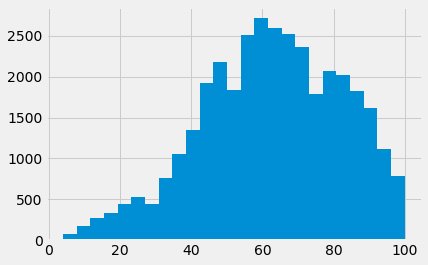

In [11]:
plt.hist(data['humidity'].dropna().values, bins=25)
plt.show()

#### Humidity is in % bounded by (0,100). Distribution seems normal

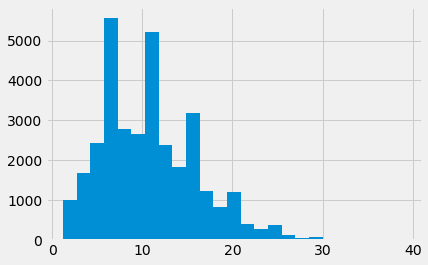

In [12]:
plt.hist(data['windspeed'].dropna().values, bins=25)
plt.show()

#### I believe windspeed is in mph, distribution seems reasonable with right tail of windy days

# Treating Missing values
### Now let's look the pattern in missing values. Based on pattern and understanding we will try to impute

In [13]:
data.apply(lambda x: sum(x.isnull()),axis=0) 

conditions    25795
windspeed      1871
winddir           0
visibility    33140
pressure        361
humidity          0
dewpoint          0
temp              0
dtype: int64

#### The categorical variables are mostly missing. But we can treat missing values of pressure and windspeed.
#### Let's look at the pattern missing values.

#### Below I am plotting the occurrence of missing value with time

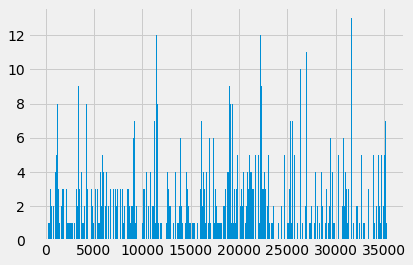

In [14]:

plt.hist(pd.isnull(data['windspeed']).nonzero()[0], bins=1000)
plt.show()

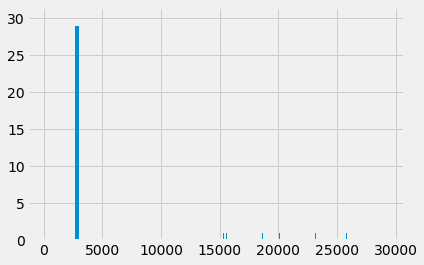

In [15]:
plt.hist(pd.isnull(data['pressure']).nonzero()[0], bins=1000)
plt.show()

#### We can see the missing values of windspeed is evenly distributed but pressure is missing for a continuous span of time

#### I think the best way to impute windspeed is interpolating. For example, if windspeed for 1:00 AM is 6 mph and 3:00 AM is 7mph, we are imputing 6.5 mph for 2:00 AM

#### For pressure, we are using 2 methods for imputation. One is interpolation for few distributed missing values and mean for the missing time span

In [16]:
data['pressure'] = data['pressure'].interpolate(limit=2, limit_direction='both')

In [17]:
data['windspeed'] = data['windspeed'].interpolate(limit=4, limit_direction='both')

In [18]:
 data['pressure'].fillna(data['pressure'].mean(), inplace=True)

In [19]:
data.apply(lambda x: sum(x.isnull()),axis=0) 

conditions    25795
windspeed         0
winddir           0
visibility    33140
pressure          0
humidity          0
dewpoint          0
temp              0
dtype: int64

# Bivariate Analysis

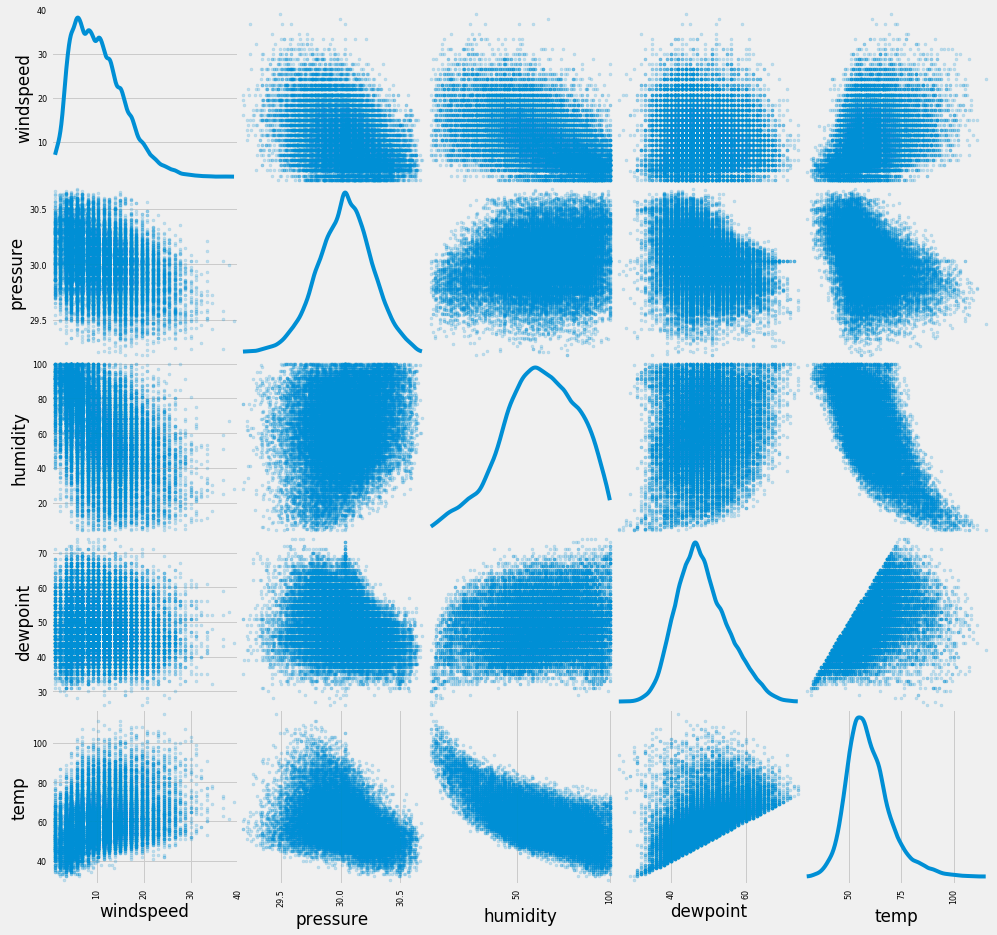

In [20]:
from pandas.tools.plotting import scatter_matrix
scatter_matrix(data.drop(['conditions', 'winddir', 'visibility'], axis=1), alpha=0.2, figsize=(15, 15), diagonal='kde')
plt.show()

### temp-humidity has negative correlation whereas dewpoint has a linear threshold function of temp

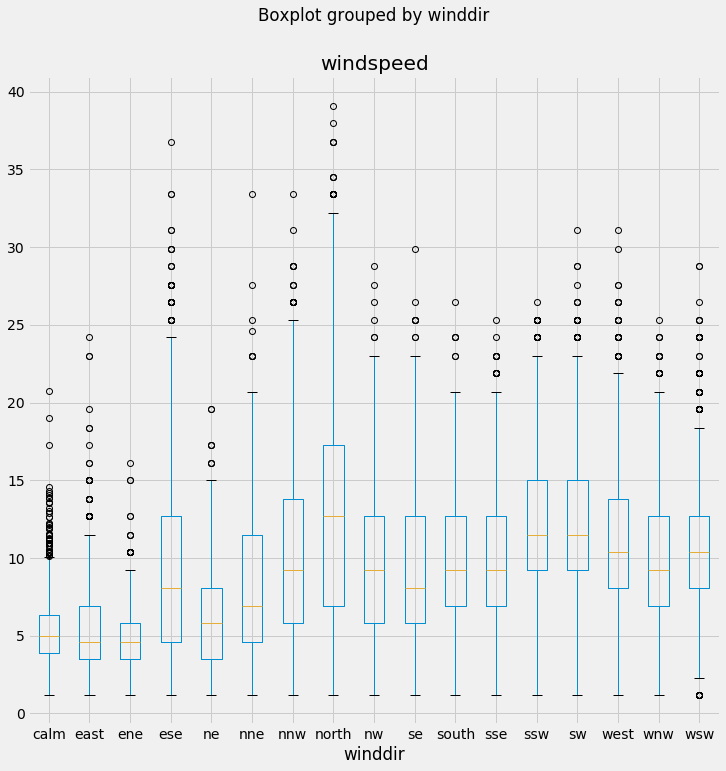

In [21]:
data.boxplot('windspeed', by = 'winddir', figsize=(12, 12))
plt.show()

### Looks like wind speed is very less in east direction. It is comparable with 'calm'

## Now let's see the historical pattern of temperature

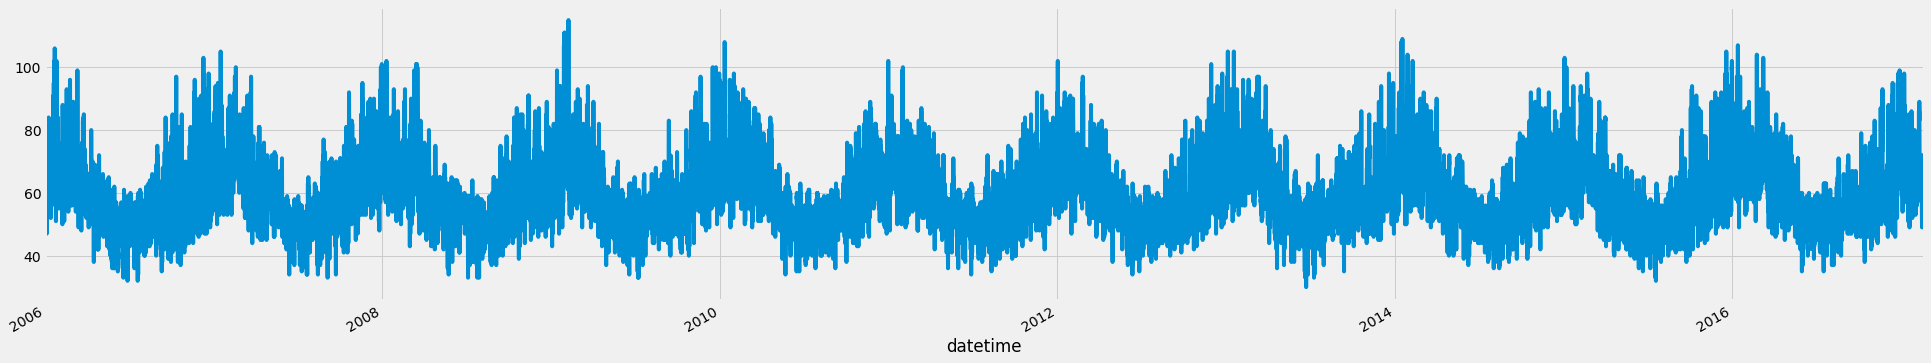

In [22]:
data['temp'].plot(figsize=(30, 6))
plt.show()

In [23]:
ts = data['temp']
ts = ts.resample('W').mean()

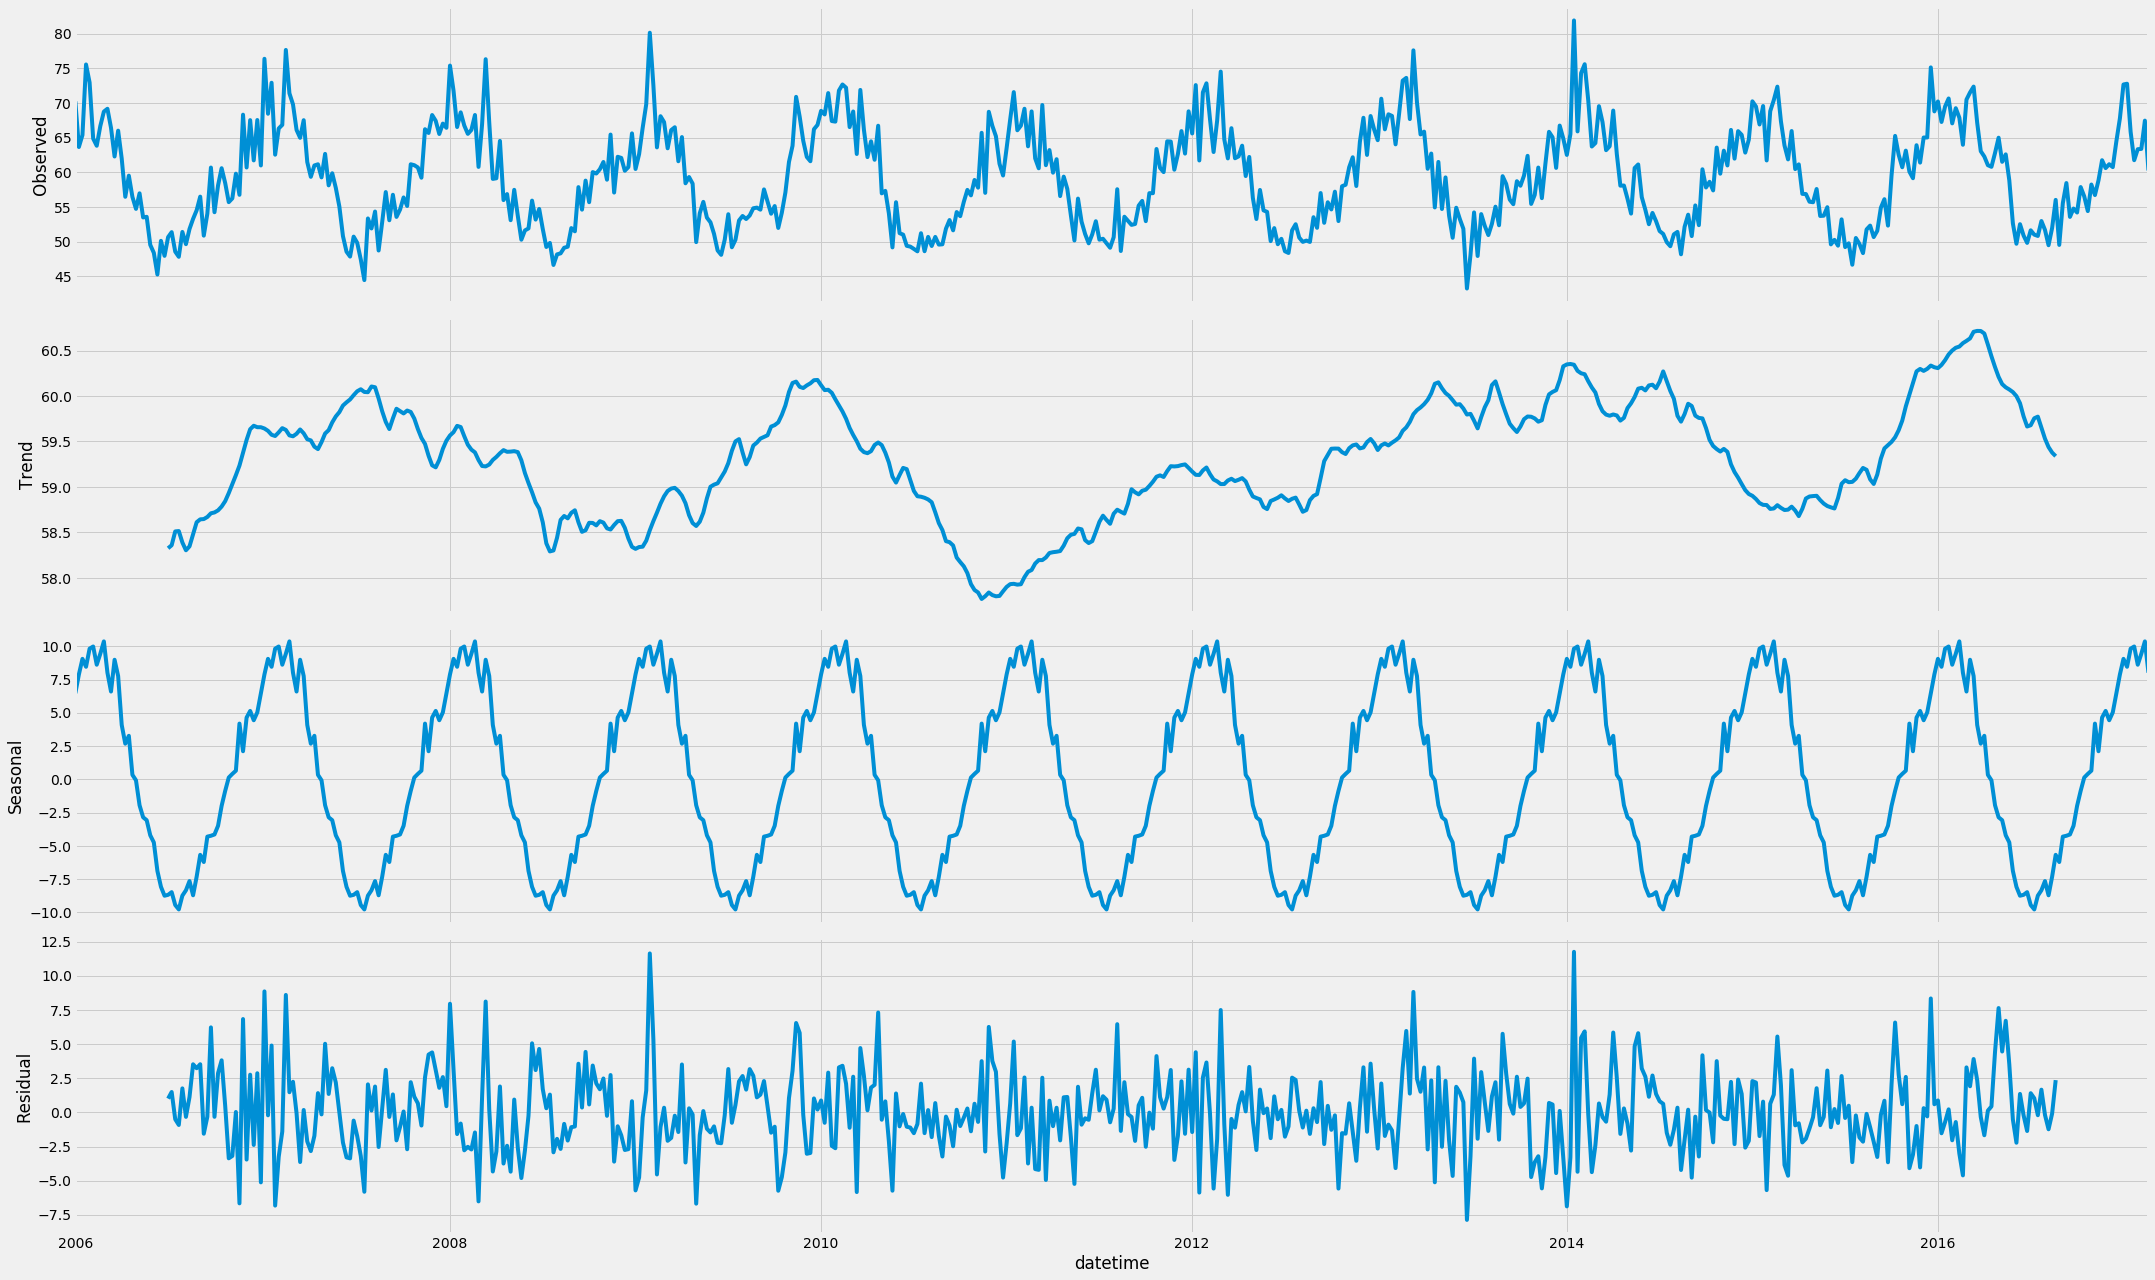

In [24]:
from pylab import rcParams
rcParams['figure.figsize'] = 30, 18

decomposition = sm.tsa.seasonal_decompose(ts, model='additive', freq=52)
fig = decomposition.plot()
plt.show()

### We can see clear yearly seasonality in temperature. There is no trend by year

## For this iteration, we will use seasonal ARIMA(p,d,q)(P,D,Q)s time series model. This model only considers the pattern of one variable.

### There are total 6 hyperparameters to train. We will use the brute force grid search to find optimum parameter. We will AIC as our judging criteria

'''

    p: is the auto-regressive part of the model. It allows us to incorporate the effect of past values into our model. Intuitively, this would be similar to stating that it is likely to be warm tomorrow if it has been warm the past 3 days.
    
    d: is the integrated part of the model. This includes terms in the model that incorporate the amount of differencing (i.e. the number of past time points to subtract from the current value) to apply to the time series. Intuitively, this would be similar to stating that it is likely to be the same temperature tomorrow if the difference in temperature in the last three days has been very small.
    
    q: is the moving average part of the model. This allows us to set the error of our model as a linear combination of the error values observed at previous time points in the past.
    
    s: is the seasonality parameter. and P Q D is same as mentioned above but for seasonal component

'''

In [25]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 52)
SARIMAX: (0, 0, 1) x (0, 1, 0, 52)
SARIMAX: (0, 1, 0) x (0, 1, 1, 52)
SARIMAX: (0, 1, 0) x (1, 0, 0, 52)


In [26]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(ts,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 1, 52) - AIC:5284.67735124717
ARIMA(0, 0, 0)x(0, 1, 1, 52) - AIC:2578.3016551892842
ARIMA(0, 0, 0)x(1, 0, 0, 52) - AIC:3161.7779452525833
ARIMA(0, 0, 0)x(1, 0, 1, 52) - AIC:2887.3151628097453
ARIMA(0, 0, 0)x(1, 1, 0, 52) - AIC:2683.8801813620503
ARIMA(0, 0, 0)x(1, 1, 1, 52) - AIC:2585.95572475708
ARIMA(0, 0, 1)x(0, 0, 0, 52) - AIC:5665.698250575827
ARIMA(0, 0, 1)x(0, 0, 1, 52) - AIC:4730.480786447366
ARIMA(0, 0, 1)x(0, 1, 0, 52) - AIC:3116.3865041942663
ARIMA(0, 0, 1)x(0, 1, 1, 52) - AIC:2565.4947704207952
ARIMA(0, 0, 1)x(1, 0, 0, 52) - AIC:3141.1455161050408
ARIMA(0, 0, 1)x(1, 0, 1, 52) - AIC:2864.6895836911663
ARIMA(0, 0, 1)x(1, 1, 0, 52) - AIC:2667.667766461731
ARIMA(0, 0, 1)x(1, 1, 1, 52) - AIC:2565.316513251406
ARIMA(0, 1, 0)x(0, 0, 1, 52) - AIC:2987.250055382527
ARIMA(0, 1, 0)x(0, 1, 1, 52) - AIC:2782.4053886668116
ARIMA(0, 1, 0)x(1, 0, 0, 52) - AIC:3006.0450697235074
ARIMA(0, 1, 0)x(1, 0, 1, 52) - AIC:2988.206661411932
ARIMA(0, 1, 0)x(1, 1, 0, 52) - AIC:289

### AIC is minimum (for non-zero p) for (1, 1, 1)x(1, 1, 1, 52) so we will use this parameter in our model. Grid search range can be further increased if there will be some pattern in residuals.

In [27]:
mod = sm.tsa.statespace.SARIMAX(ts,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 52),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1830      0.043      4.250      0.000       0.099       0.267
ma.L1         -1.0371      0.017    -61.539      0.000      -1.070      -1.004
ar.S.L52      -0.2069      0.051     -4.061      0.000      -0.307      -0.107
ma.S.L52      -0.8006      0.059    -13.666      0.000      -0.915      -0.686
sigma2        10.5420      0.634     16.625      0.000       9.299      11.785


### The coef column shows the weight (i.e. importance) of each feature and how each one impacts the time series. The P>|z| column informs us of the significance of each feature weight. Here, each weight has a p-value lower or close to zero, so it is reasonable to retain all of them in our model.

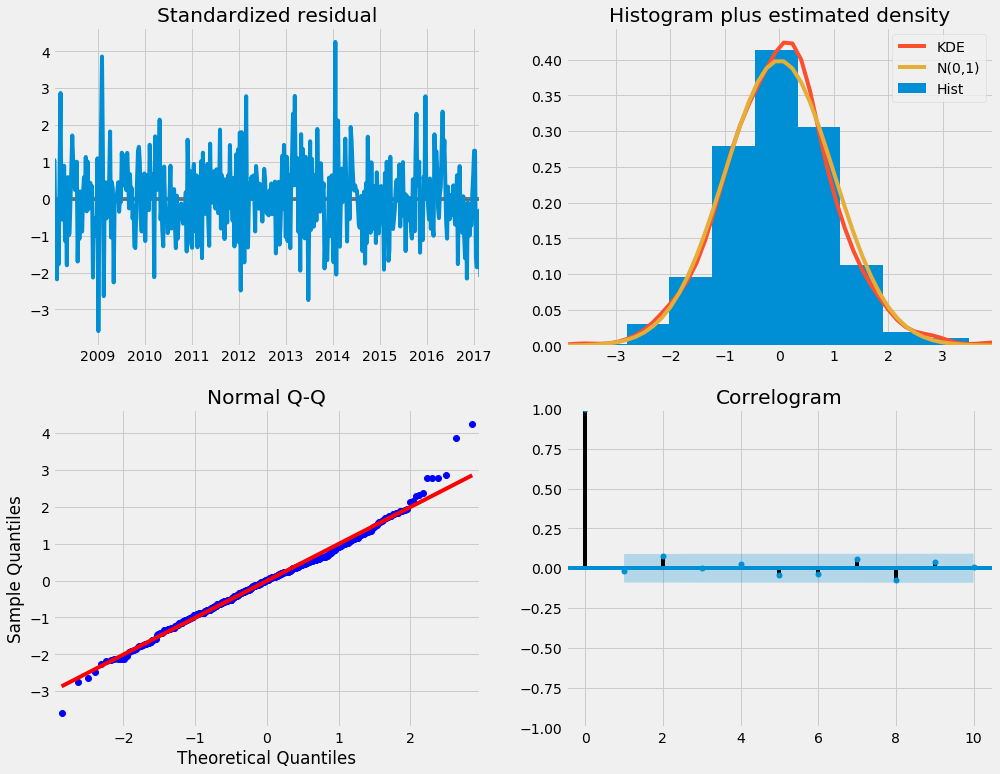

In [28]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()


### The above charts are useful in understanding patterns in residual. It is desirable to have residuals uncorrelated and normally distributed with zero-mean.

#### All 4 charts are suggesting that residuals are white noise. If we find any pattern that means we can further improve model by expanding the grid search 

# Validation

### We will validate our model with 2 approaches. First with one step ahead forecast and second with dynamic forecast.

In [29]:
pred = results.get_prediction(start=pd.to_datetime('2015-01-04'), dynamic=False)
pred_ci = pred.conf_int()

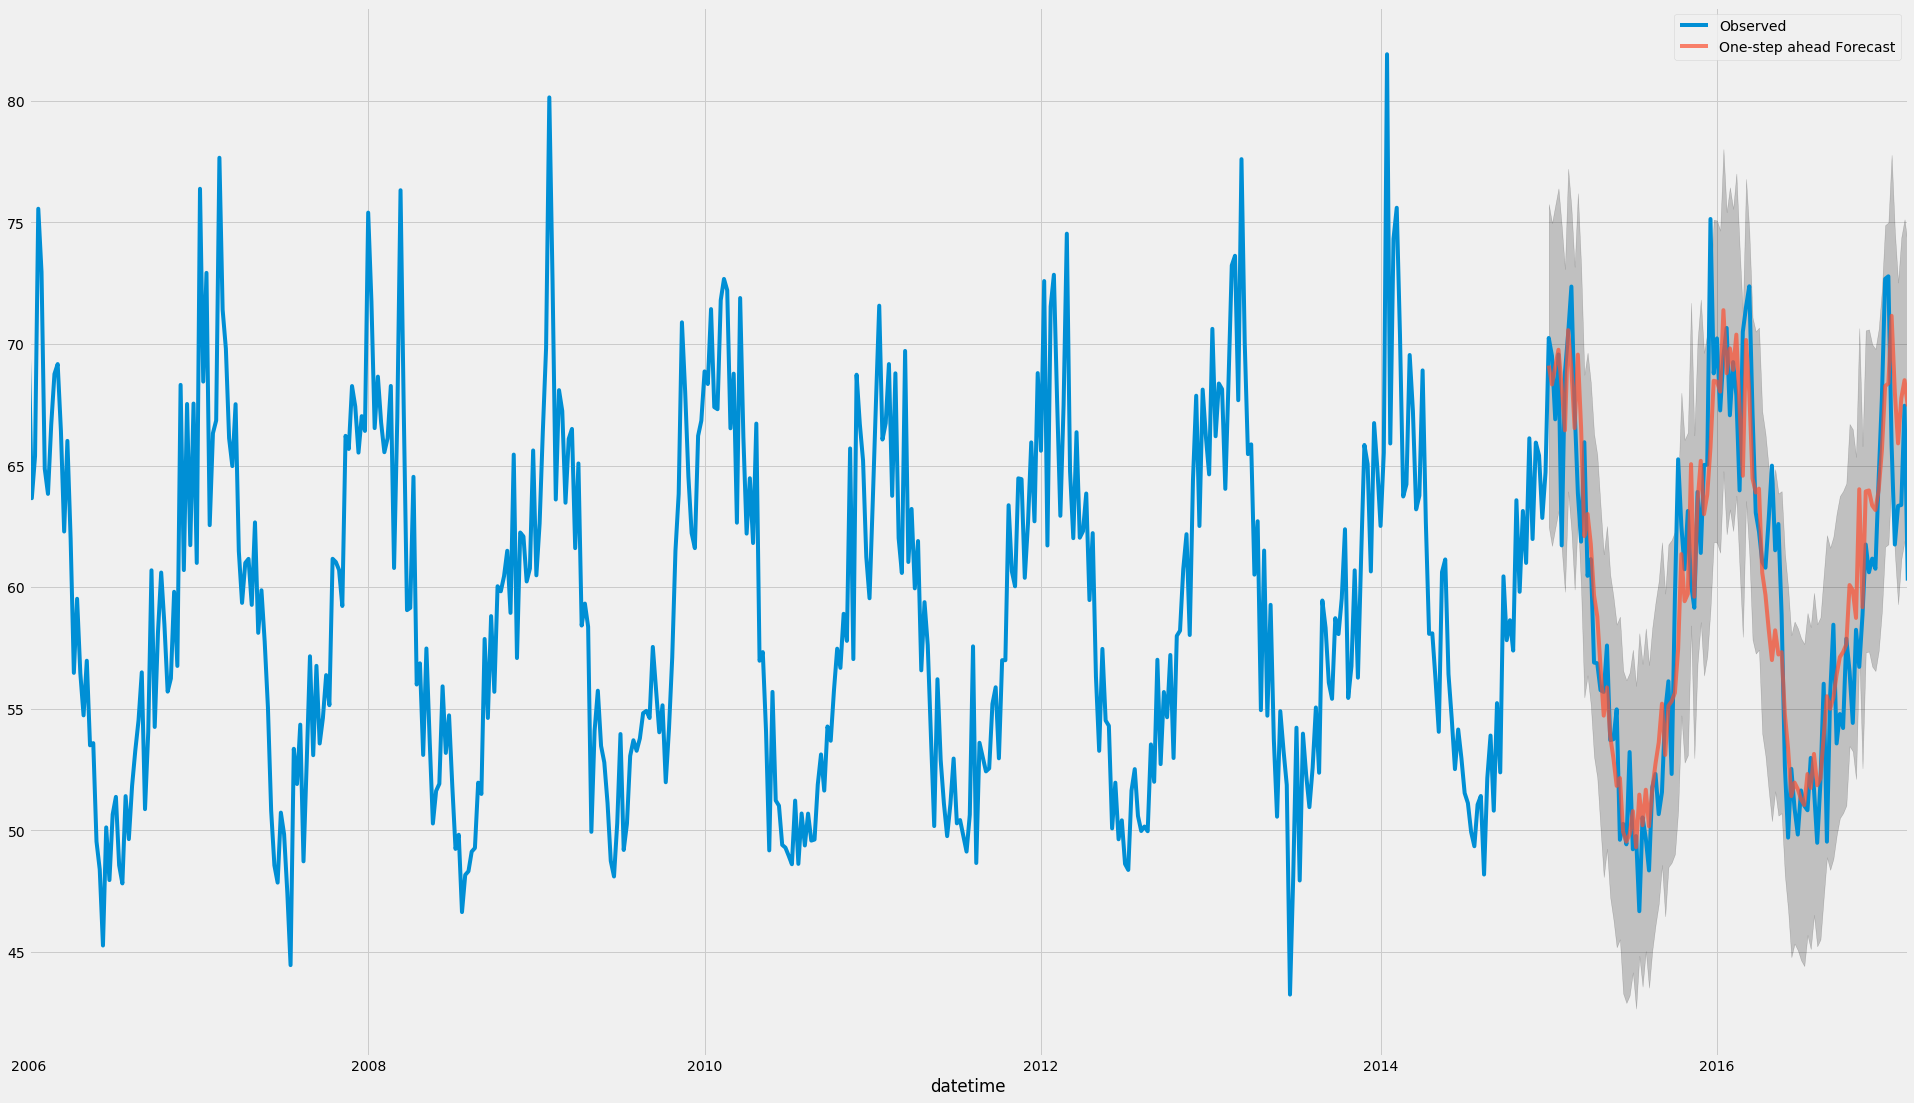

In [30]:
ax = ts['2006':].plot(label='Observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

plt.legend()

plt.show()

In [31]:
y_forecasted = pred.predicted_mean
y_truth = ts['2015-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 10.11


In [32]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('2015-01-04'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

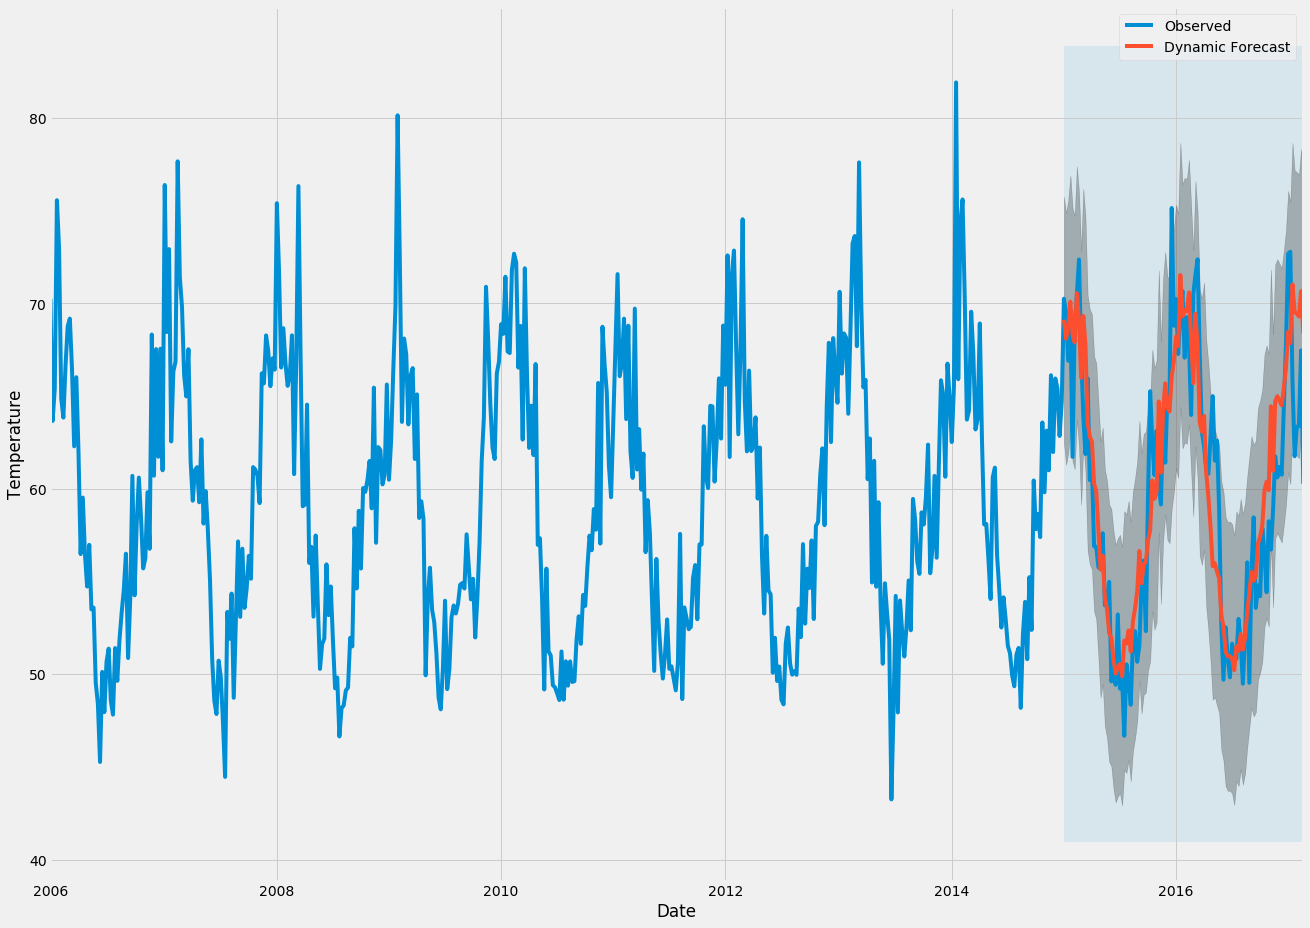

In [33]:
ax = ts['2006':].plot(label='Observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2015-01-01'), ts.index[-1],
                 alpha=.1, zorder=-1)
ax.set_xlabel('Date')
ax.set_ylabel('Temperature')


plt.legend()
plt.show()

# Forecast


In [34]:
pred_uc = results.get_forecast(steps=150)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

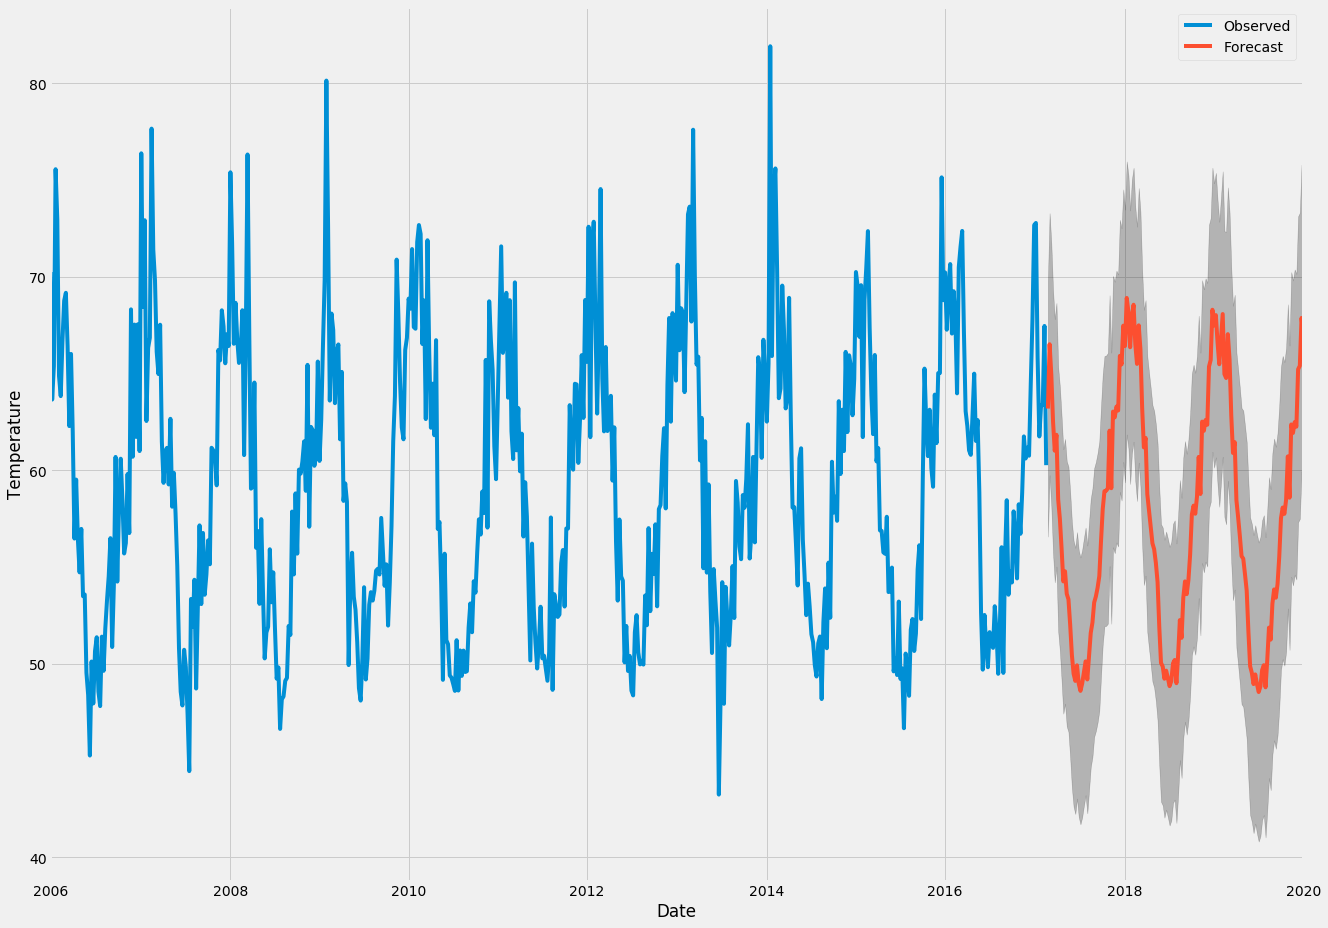

In [35]:
ax = ts.plot(label='Observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Temperature')

plt.legend()
plt.show()

# Next Steps

## The model we have tried only consider the pattern of one variable. We can refine our model in the following ways:

### 1. We can try VAR(Vector autoregression) model to capture the patterns of all 5 numeric variables in forecast of all others.
### 2. We can do feature engineering in all variables like '5 days moving avg temp', ' 20 days moving avg pressure' etc. and build regression model for one time step ahead
### 3. We can use a recurrent neural network to learn on sequential data and forecast.

## I believe RNN can outperform others because it can easily learn seasonality and can do feature engineering. Also, ARIMA/VAR model struggles with more complexity and more data.